## Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datasets import load_dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import random
from tqdm import tqdm

import time
import copy
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"L'entraînement se fera sur : {device}")

/home/seye/.conda/envs/HDDLtorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


L'entraînement se fera sur : cuda


# Motivation du choix des Datasets

Pour sélectionner des datasets pertinents pour une comparaison rigoureuse, nous nous sommes basés sur les différences fondamentales de fonctionnement entre les deux architectures identifiées dans la littérature :

- Hypothèse CNN (Fort Biais Inductif) : Les CNNs, grâce à leurs opérations de convolution, possèdent un fort biais inductif (invariance par translation, localité). Ils sont théoriquement capables de généraliser efficacement même sur des images de faible résolution et des volumes de données modérés.

- Hypothèse ViT (Faible Biais Inductif) : Les Vision Transformers traitent l'image comme une séquence globale de "patches" sans hypothèses spatiales. Ils nécessitent généralement une plus grande résolution (pour avoir suffisamment de patches) et un volume de données massif pour apprendre les relations spatiales, risquant le surapprentissage sur de petits datasets.

Pour vérifier ces hypothèses et observer la transition de performance, nous avons sélectionné deux datasets aux caractéristiques distinctes:

- CIFAR-10 : Un dataset standard comportant 60 000 images couleur (50 000 pour l'entraînement, 10 000 pour le test) réparties équitablement en 10 classes. Avec une faible résolution de 32×32 pixels, ce dataset représente un défi pour le ViT standard (qui se retrouve avec très peu de patches) et servira de "baseline" favorable aux CNNs.

- Tiny ImageNet : Une version réduite du célèbre ImageNet, contenant 100 000 images d'entraînement et 10 000 images de validation, réparties en 200 classes (soit 500 images par classe). Avec une résolution de 64×64 pixels, il offre 4 fois plus de pixels que CIFAR-10 et une complexité de classification accrue, permettant de tester la capacité de généralisation des modèles.

Nous implémenterons les deux architectures "from scratch" pour comparer leurs performances sur ces deux échelles de complexité.

# Architecture ViT

Le ViT traite l'image comme une séquence de tokens. Le découpage standard de 16×16 pixels, conçu pour des images haute résolution (224×224), est inadapté à nos datasets (CIFAR-10, 32×32). En effet, cela ne génèrerait que 2×2=4 patches, un nombre insuffisant pour que le mécanisme d'Attention apprenne des dépendances spatiales complexes. Nous réduisons donc la taille des patches à 4×4 pixels. Cela permet de générer une séquence de 8×8=64 tokens, offrant un meilleur apprentissage.

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=4, embed_dim=128):
        super().__init__()
        self.patch_size = patch_size

        # On utilise une Conv2d avec kernel_size = stride = patch_size pour découper et projeter linéairement.
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x shape: (Batch, C, H, W)
        x = self.projection(x) # (Batch, Embed_Dim, H/P, W/P)
        x = x.flatten(2)       # (Batch, Embed_Dim, N_Patches)
        x = x.transpose(1, 2)  # (Batch, N_Patches, Embed_Dim) -> Format attendu par le Transformer
        return x

La classe TransformerBlock est composée de deux sous-modules séquentiels connectés par des liens résiduels (skip connections) : un mécanisme de Self-Attention Multi-têtes (permettant à chaque patch d'intégrer l'information de tous les autres patches de l'image globalement) suivi d'un réseau de neurones MLP.

ici on utilise la LayerNorm qui stabilise l'apprentissage en normalisant les vecteurs de chaque échantillon individuellement (indépendamment des autres images du batch).

In [3]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, pf_dim, dropout=0.1):
        super().__init__()
        # 1. Self-Attention
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        # 2. Feed Forward (MLP)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, pf_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(pf_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Attention avec connexion résiduelle (Skip connection)
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out

        # MLP avec connexion résiduelle
        x = x + self.mlp(self.norm2(x))
        return x

Pour la classe finale qui assemble le tout, on va introduire 2 nouveaux concepts

- Le Token CLS (self.cls_token): C'est un vecteur apprenable unique ajouté en début de séquence (index 0). Grâce au mécanisme d'attention, il agrège les informations de tous les autres patches au fil des couches. C'est ce vecteur qui est utilisé pour prédire la classe de l'image.

- L'Embedding de Position (self.pos_embed): ce paramètre est additionné aux embeddings des patches pour injecter l'information spatiale. Il permet au modèle de distinguer la géométrie de l'image (savoir qu'un patch est en haut à gauche et non en bas à droite par exemple).

In [4]:
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, embed_dim=128, depth=6, num_heads=4, pf_dim=256, dropout=0.1):
        super().__init__()

        assert img_size % patch_size == 0, "L'image doit être divisible par la taille du patch."
        num_patches = (img_size // patch_size) ** 2

        # Patch Embedding
        self.patch_embed = PatchEmbedding(in_channels, patch_size, embed_dim)

        # CLS Token & Positional Embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim)) # +1 car on a ajouté le CLS token
        self.pos_drop = nn.Dropout(dropout)

        # Transformer Encoder
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, pf_dim, dropout)
            for _ in range(depth)
        ])

        # Tête de classification finale
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]

        x = self.patch_embed(x)

        # B. Ajout du CLS Token
        # On duplique le token pour chaque image du batch
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) # (Batch, N_Patches + 1, Embed_Dim)

        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        # On ne garde que le CLS token (index 0) pour la prédiction
        cls_token_final = x[:, 0]
        return self.head(cls_token_final)

# Architecture CNN

Pour établir une baseline solide face aux Vision Transformers, nous avons implémenté et entraîné deux architectures de Convolutional Neural Networks (CNN) en partant de zéro :

Le VGG Simplifié : Une architecture séquentielle classique qui empile convolutions et max pooling.

Le ResNet-18 (Simplifié) : Une architecture plus moderne intégrant des connexions résiduelles (skip connections). Cela nous a permis d'aller plus profond (18 couches) sans perdre le signal d'apprentissage.

## Fonctions nécessaires pour CNN

In [5]:
def plot_confusion_matrix_cnn(model, test_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie Classe')
    plt.title('Matrice de Confusion')
    plt.show()


def evaluate_test_accuracy_cnn(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy finale sur le jeu de test (10,000 images) : {accuracy:.2f} %')

def train_model_cnn(model, train_loader, val_loader, epochs, patience=5):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())

    start_time = time.time()
    total = 0
    correct = 0
    for epoch in range(epochs):
        # Entraînement
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_acc = 100 * correct / total
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_acc = 100 * correct / total
        scheduler.step(avg_val_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}%")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping déclenché après {epoch+1} époques !")
                break

    total_time = time.time() - start_time
    print(f"Temps total d'entraînement : {total_time:.2f}s")
    model.load_state_dict(best_model_wts)

    return train_losses, val_losses, train_accuracies, val_accuracies



def plot_training_results_cnn(history):
    train_losses, val_losses, train_accuracies , val_accuracies = history

    plt.figure(figsize=(12, 5))

    # Courbe de Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Courbe d'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy', color='green')
    plt.plot(train_accuracies, label='Train Accuracy', color='orange')
    plt.plot()
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



## VGG

Architecture VGG adaptée pour des images Cifar 10 et Tiny ImageNet. Empilement linéaire de couches de convolution (3×3) et de BatchNorm. Utilisation  de Max Pooling (2×2) après chaque bloc pour diviser la taille de l'image par 2.

### vgg cifar 10

In [6]:
class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()

        # taille img entrée : 3 x 32 x 32
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # Padding=1 préserve la dimension
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 16x16

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 8x8

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # taille: 4x4
        )

        # Classifieur : Fully Connected
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), # transforme (batch_size, 256, 4, 4) en (batch_size, 256, 1, 1)
            nn.Flatten(),
            #nn.Linear(256 * 8 * 8, 512),
            #nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

vgg = VGG(num_classes=10).to(device)
print(f"Nombre de paramètres : {sum(p.numel() for p in vgg.parameters() if p.requires_grad)}")





Nombre de paramètres : 539786


### vgg tiny ImageNet

In [7]:
class VGG_TinyImageNet(nn.Module):
    def __init__(self, num_classes=200):
        super(VGG_TinyImageNet, self).__init__()

        # taille img entrée : 3 x 64 x 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # Padding=1 préserve la dimension
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classifieur : Fully Connected
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

vgg_tiny = VGG_TinyImageNet(num_classes=200).to(device)
print(f"Nombre de paramètres : {sum(p.numel() for p in vgg_tiny.parameters() if p.requires_grad)}")


Nombre de paramètres : 2246088


## RESNET

Introduction du "Shortcut" (x+F(x)) pour éviter la disparition du gradient.

Réduction de dimension : Suppression du Max Pooling intermédiaire. La réduction se fait par des convolutions avec Stride = 2. Architecture plus profonde (~18 couches) rendue possible par les blocs résiduels.

### resnet cifar 10


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # F(x) + x
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleResNet, self).__init__()
        self.in_channels = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.layer1 = self._make_layer(32, 2, stride=1)
        self.layer2 = self._make_layer(64, 2, stride=2)
        self.layer3 = self._make_layer(128, 2, stride=2)
        self.layer4 = self._make_layer(256, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Ajout de Dropout avant la couche finale
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # On éteint 50% des neurones aléatoirement
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        out = self.classifier(out)
        return out

resnet = SimpleResNet(num_classes=10).to(device)

print(f"Modèle : ResNet Simplifié")
print(f"Nombre de paramètres : {sum(p.numel() for p in resnet.parameters() if p.requires_grad):,}")



Modèle : ResNet Simplifié
Nombre de paramètres : 2,797,610


### resnet tiny ImageNet

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        # F(x) + x
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleResNet_tiny(nn.Module):
    def __init__(self, num_classes=200):
        super(SimpleResNet_tiny, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Ajout de Dropout avant la couche finale
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # On éteint 50% des neurones aléatoirement
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)

        out = self.classifier(out)
        return out

resnet_tiny = SimpleResNet_tiny(num_classes=200).to(device)

print(f"Modèle : ResNet Simplifié")
print(f"Nombre de paramètres : {sum(p.numel() for p in resnet_tiny.parameters() if p.requires_grad):,}")




Modèle : ResNet Simplifié
Nombre de paramètres : 11,271,432


# Train and Test functions

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    """
    Entraîne le modèle et affiche les courbes d'évolution.
    """
    model = model.to(device)

    # Historique pour les tracés
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    print(f"Démarrage de l'entraînement pour {num_epochs} époques...")

    for epoch in range(num_epochs):
        start_time = time.time()

        # --- PHASE D'ENTRAÎNEMENT ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Barre de progression
        loop = tqdm(train_loader, leave=False)
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Stats train
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Mise à jour barre de progression
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train

        # --- PHASE DE VALIDATION ---
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct_val / total_val

        # Stockage
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}% | "
              f"Time: {time.time() - start_time:.1f}s")

    # --- TRACÉ DES COURBES ---
    plt.figure(figsize=(12, 5))

    # Courbe de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Courbe d'Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Évolution de l\'Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.show()

    return history

In [11]:
def evaluate_model(model, test_loader, classes, device='cuda'):
    """
    Calcule l'accuracy finale et affiche la matrice de confusion.
    """
    model.eval()
    all_preds = []
    all_labels = []

    print("Évaluation du modèle...")
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcul des métriques
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\nAccuracy Finale sur le jeu de test : {acc*100:.2f}%")

    if len(classes) <= 10:
      # Affichage de la matrice
      plt.figure(figsize=(10, 8))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=classes, yticklabels=classes)
      plt.xlabel('Prédiction')
      plt.ylabel('Vraie Classe')
      plt.title('Matrice de Confusion')
      plt.show()

# Définition des classes CIFAR-10 pour l'affichage
classes = ('plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')

# CIFAR-10


## CNN

### Preprocessing

In [12]:
batch_size = 64 # le réseau traite par paquets de 64 imgs au lieu de 50000 (sinon explosion de la mémoire RAM/GPU)
learning_rate = 0.001
epochs = 10

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # data augmentation : recadrage aléatoire avec padding de 4 pixels
    transforms.RandomHorizontalFlip(p=0.5), # data augmentation : retournement horizontal aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1), # data augmentation : modification aléatoire de la luminosité, contraste et saturation
    transforms.ToTensor(), # img classique codée entre 0 et 255, ici on divise par 255 pour avoir entre 0 et 1 (meilleur pour l'apprentissage)
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # apprentissage rapide si les données ont m=0 et sigma proche de 1 (mR, mG, mB),(sigmaR, sigmaG, sigmaB)

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # valeurs prise sur google (normalisation cifar-10)
])

full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(full_trainset)) # 40 000
val_size = len(full_trainset) - train_size # 10 000
train_dataset, val_dataset = random_split(full_trainset, [train_size, val_size])

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(f"Données chargées : Train ({len(train_dataset)}), Val ({len(val_dataset)}), Test ({len(testset)})")

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')



Données chargées : Train (40000), Val (10000), Test (10000)


### VGG

Epoch [1/50] Train Loss: 0.3210 | Val Loss: 0.4297 | Train Acc: 89.08% | Val Acc: 85.73%
Epoch [2/50] Train Loss: 0.3284 | Val Loss: 0.4540 | Train Acc: 88.33% | Val Acc: 84.71%
Epoch [3/50] Train Loss: 0.3239 | Val Loss: 0.4615 | Train Acc: 88.05% | Val Acc: 84.91%
Epoch [4/50] Train Loss: 0.3217 | Val Loss: 0.4144 | Train Acc: 88.08% | Val Acc: 85.86%
Epoch [5/50] Train Loss: 0.3172 | Val Loss: 0.4581 | Train Acc: 88.62% | Val Acc: 85.34%
Epoch [6/50] Train Loss: 0.3104 | Val Loss: 0.4344 | Train Acc: 88.57% | Val Acc: 85.00%
Epoch [7/50] Train Loss: 0.3130 | Val Loss: 0.4649 | Train Acc: 88.46% | Val Acc: 84.73%
Epoch [8/50] Train Loss: 0.3013 | Val Loss: 0.4345 | Train Acc: 88.69% | Val Acc: 85.54%
Epoch [9/50] Train Loss: 0.2337 | Val Loss: 0.3594 | Train Acc: 90.81% | Val Acc: 88.05%
Epoch [10/50] Train Loss: 0.2094 | Val Loss: 0.3497 | Train Acc: 91.99% | Val Acc: 87.99%
Epoch [11/50] Train Loss: 0.1979 | Val Loss: 0.3512 | Train Acc: 92.31% | Val Acc: 88.08%
Epoch [12/50] Train

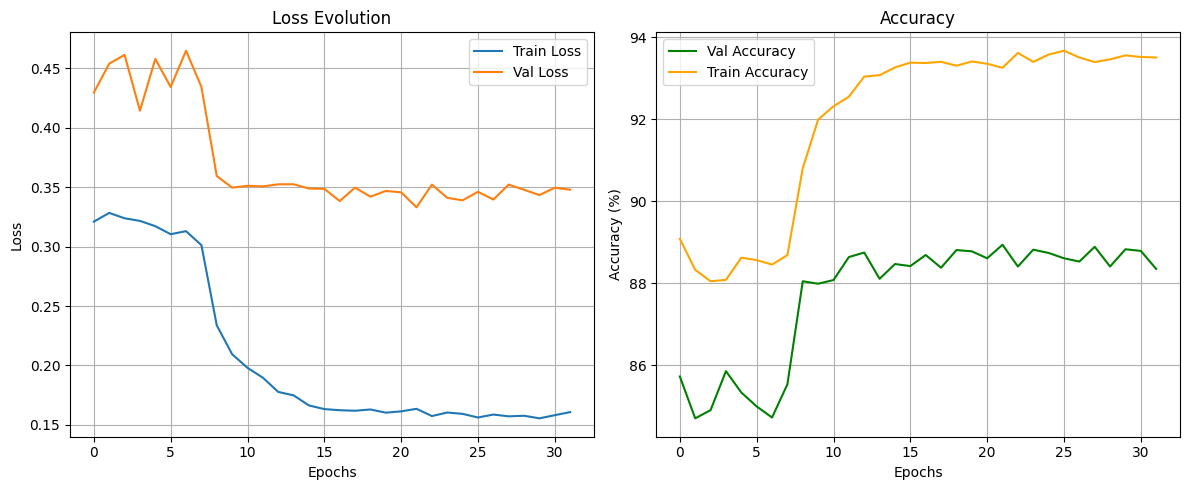

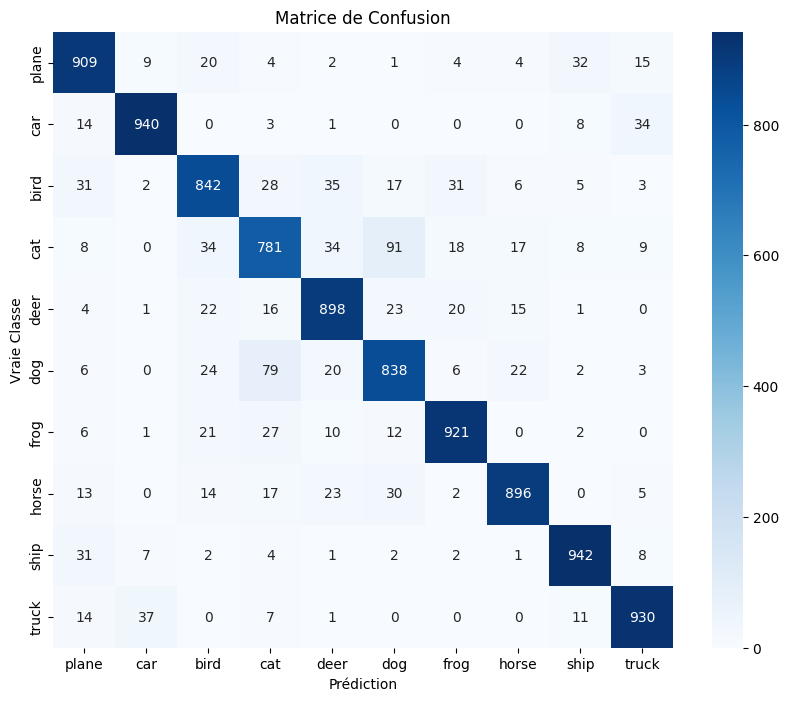

Accuracy finale sur le jeu de test (10,000 images) : 88.97 %


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=learning_rate, weight_decay=1e-4) #pénalité L2 pour éviter l'overfitting
#optimizer = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4) #5e-4
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
history_vgg = train_model_cnn(vgg, trainloader, valloader, epochs=50, patience=10)


import os
os.makedirs('models', exist_ok=True)
save_path = 'models/vgg_cifar10_final.pth'
torch.save(vgg.state_dict(), save_path)

print(f"Modèle sauvegardé avec succès ici : {save_path}")


plot_training_results_cnn(history_vgg)
plot_confusion_matrix_cnn(vgg, testloader, classes)
evaluate_test_accuracy_cnn(vgg, testloader, device)

### RESNET

Epoch [1/50] Train Loss: 1.5663 | Val Loss: 1.4824 | Train Acc: 42.55% | Val Acc: 47.78%
Epoch [2/50] Train Loss: 1.1129 | Val Loss: 0.9991 | Train Acc: 57.66% | Val Acc: 65.04%
Epoch [3/50] Train Loss: 0.9370 | Val Loss: 0.8666 | Train Acc: 66.70% | Val Acc: 69.17%
Epoch [4/50] Train Loss: 0.8125 | Val Loss: 0.8760 | Train Acc: 71.56% | Val Acc: 70.05%
Epoch [5/50] Train Loss: 0.7208 | Val Loss: 0.7196 | Train Acc: 74.32% | Val Acc: 75.45%
Epoch [6/50] Train Loss: 0.6656 | Val Loss: 0.6061 | Train Acc: 76.85% | Val Acc: 79.28%
Epoch [7/50] Train Loss: 0.6149 | Val Loss: 0.6438 | Train Acc: 79.17% | Val Acc: 77.96%
Epoch [8/50] Train Loss: 0.5751 | Val Loss: 0.5807 | Train Acc: 80.09% | Val Acc: 80.18%
Epoch [9/50] Train Loss: 0.5420 | Val Loss: 0.5497 | Train Acc: 81.48% | Val Acc: 80.85%
Epoch [10/50] Train Loss: 0.5128 | Val Loss: 0.5702 | Train Acc: 82.45% | Val Acc: 81.17%
Epoch [11/50] Train Loss: 0.4886 | Val Loss: 0.5271 | Train Acc: 83.03% | Val Acc: 81.59%
Epoch [12/50] Train

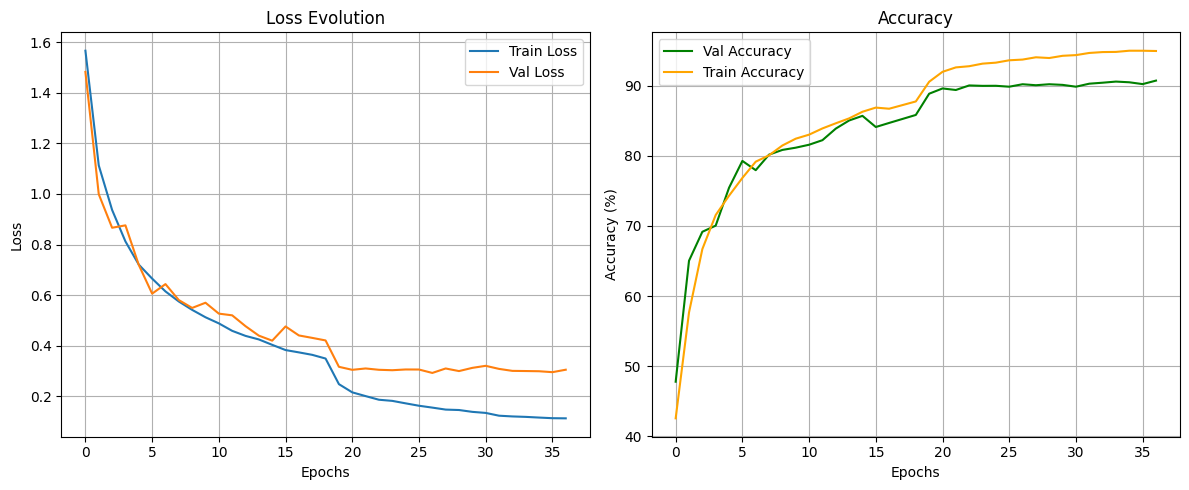

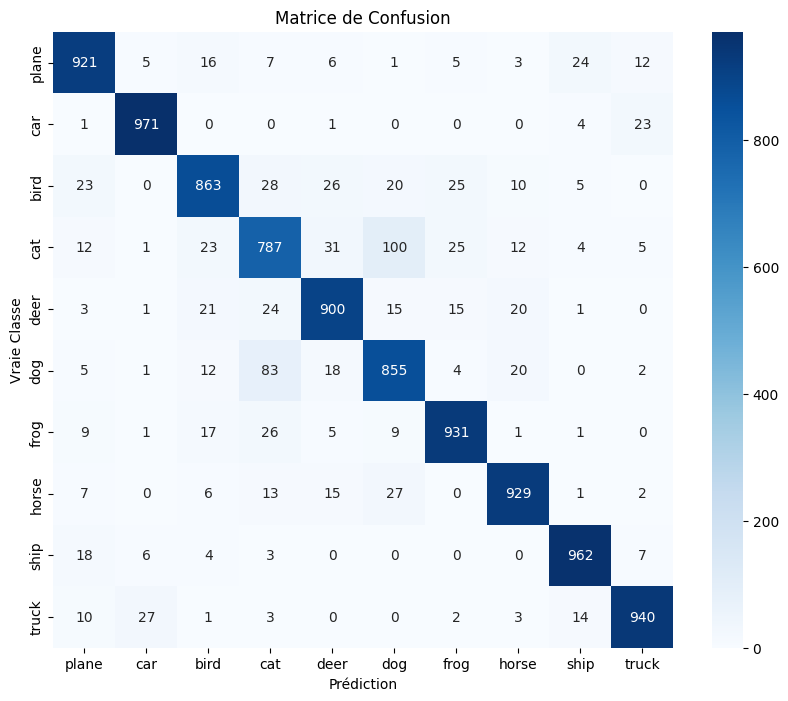

Accuracy finale sur le jeu de test (10,000 images) : 90.59 %


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
history_resnet = train_model_cnn(resnet, trainloader, valloader, epochs=50, patience=10)


import os
os.makedirs('models', exist_ok=True)
save_path = 'models/resnet_cifar10_final.pth'
torch.save(resnet.state_dict(), save_path)


plot_training_results_cnn(history_resnet)
plot_confusion_matrix_cnn(resnet, testloader, classes)
evaluate_test_accuracy_cnn(resnet, testloader, device)

## VIT

In [16]:




transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Définition des classes CIFAR-10 pour l'affichage
classes = ('plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')

val_size = 5000
train_size = len(trainset) - val_size

# Utilisation du générateur pour garantir que le split est toujours le même (Reproductibilité)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(trainset, [train_size, val_size], generator=generator)

batch_size = 64

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Données chargées :")
print(f"- Train : {len(train_dataset)} images")
print(f"- Val   : {len(val_dataset)} images")
print(f"- Test  : {len(testset)} images")

Données chargées :
- Train : 45000 images
- Val   : 5000 images
- Test  : 10000 images


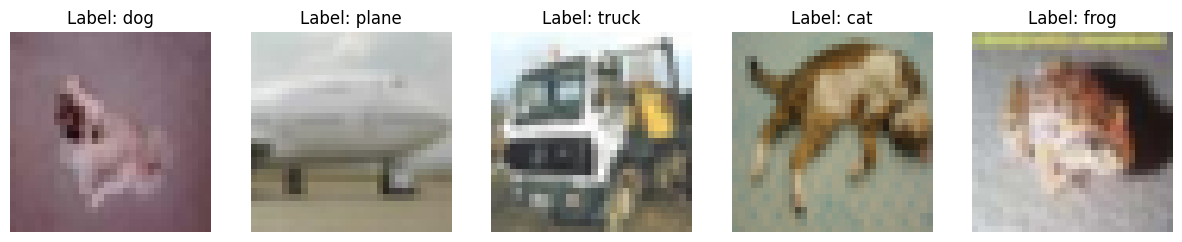

In [17]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    plt.imshow(img)

# images aléatoires du trainloader
dataiter = iter(trainloader)
images, labels = next(dataiter)


plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    imshow(images[i])
    ax.set_title(f"Label: {classes[labels[i]]}")
    plt.axis('off')

plt.show()

In [18]:
def visualize_patches(image, patch_size):
    # image: (C, H, W) tensor
    # patch_size: int

    C, H, W = image.shape
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch_size."

    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    fig, axes = plt.subplots(num_patches_h, num_patches_w, figsize=(num_patches_w * 1.5, num_patches_h * 1.5))
    axes = axes.flatten()

    patch_idx = 0
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # Extract the patch
            patch = image[:, i * patch_size : (i + 1) * patch_size, j * patch_size : (j + 1) * patch_size]

            # Convert to numpy and transpose for matplotlib (H, W, C)
            patch_np = patch.permute(1, 2, 0).cpu().numpy()

            ax = axes[patch_idx]
            ax.imshow(np.clip(patch_np, 0, 1))
            ax.set_title(f'Patch {patch_idx+1}', fontsize=8)
            ax.axis('off')
            patch_idx += 1

    plt.suptitle(f'Image divisée en patches de {patch_size}x{patch_size}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [ ]:
model_vit = ViT(img_size=32, patch_size=4, num_classes=10, embed_dim=128, depth=6, num_heads=4).to(device)

print(f"Nombre de paramètres : {sum(p.numel() for p in model_vit.parameters() if p.requires_grad)}")
# 2. Hyperparamètres
# AdamW est recommandé pour les Transformers
optimizer = optim.AdamW(model_vit.parameters(), lr=3e-4, weight_decay=5e-2)
criterion = nn.CrossEntropyLoss()

Nombre de paramètres : 811146


Démarrage de l'entraînement pour 30 époques...


Epoch 1/30 | Train Loss: 2.0286 Acc: 24.37% | Val Loss: 1.8317 Acc: 33.84% | Time: 26.0s


Epoch 2/30 | Train Loss: 1.8054 Acc: 34.77% | Val Loss: 1.6680 Acc: 40.66% | Time: 24.0s


Epoch 3/30 | Train Loss: 1.6961 Acc: 39.19% | Val Loss: 1.6180 Acc: 41.54% | Time: 23.9s


Epoch 4/30 | Train Loss: 1.6054 Acc: 41.92% | Val Loss: 1.5060 Acc: 45.42% | Time: 23.6s


Epoch 5/30 | Train Loss: 1.5349 Acc: 44.60% | Val Loss: 1.4444 Acc: 48.42% | Time: 24.4s


Epoch 6/30 | Train Loss: 1.4921 Acc: 46.07% | Val Loss: 1.4370 Acc: 48.66% | Time: 24.0s


Epoch 7/30 | Train Loss: 1.4478 Acc: 47.84% | Val Loss: 1.4125 Acc: 50.12% | Time: 23.1s


Epoch 8/30 | Train Loss: 1.4123 Acc: 49.11% | Val Loss: 1.3423 Acc: 51.88% | Time: 23.7s


Epoch 9/30 | Train Loss: 1.3787 Acc: 50.26% | Val Loss: 1.3196 Acc: 52.74% | Time: 24.1s


Epoch 10/30 | Train Loss: 1.3453 Acc: 51.40% | Val Loss: 1.3057 Acc: 52.42% | Time: 23.9s


Epoch 11/30 | Train Loss: 1.3157 Acc: 52.45% | Val Loss: 1.2662 Acc: 55.52% | Time: 24.0s


Epoch 12/30 | Train Loss: 1.2853 Acc: 53.60% | Val Loss: 1.2350 Acc: 55.68% | Time: 23.9s


Epoch 13/30 | Train Loss: 1.2614 Acc: 54.38% | Val Loss: 1.2235 Acc: 56.24% | Time: 24.1s


Epoch 14/30 | Train Loss: 1.2379 Acc: 55.62% | Val Loss: 1.1878 Acc: 57.50% | Time: 24.1s


Epoch 15/30 | Train Loss: 1.2099 Acc: 56.50% | Val Loss: 1.1924 Acc: 57.14% | Time: 22.3s


Epoch 16/30 | Train Loss: 1.1926 Acc: 57.09% | Val Loss: 1.1943 Acc: 57.78% | Time: 23.1s


Epoch 17/30 | Train Loss: 1.1686 Acc: 58.14% | Val Loss: 1.1370 Acc: 59.06% | Time: 23.1s


Epoch 18/30 | Train Loss: 1.1469 Acc: 58.99% | Val Loss: 1.1287 Acc: 59.94% | Time: 23.1s


Epoch 19/30 | Train Loss: 1.1254 Acc: 59.82% | Val Loss: 1.1150 Acc: 59.66% | Time: 23.3s


Epoch 20/30 | Train Loss: 1.1080 Acc: 60.36% | Val Loss: 1.1260 Acc: 59.76% | Time: 23.2s


Epoch 21/30 | Train Loss: 1.0875 Acc: 61.11% | Val Loss: 1.0829 Acc: 61.72% | Time: 22.8s


Epoch 22/30 | Train Loss: 1.0708 Acc: 61.75% | Val Loss: 1.1048 Acc: 61.28% | Time: 23.0s


Epoch 23/30 | Train Loss: 1.0545 Acc: 62.20% | Val Loss: 1.0742 Acc: 62.82% | Time: 22.9s


Epoch 24/30 | Train Loss: 1.0394 Acc: 62.79% | Val Loss: 1.0580 Acc: 62.00% | Time: 22.8s


Epoch 25/30 | Train Loss: 1.0199 Acc: 63.60% | Val Loss: 1.0794 Acc: 62.44% | Time: 22.8s


Epoch 26/30 | Train Loss: 1.0053 Acc: 63.96% | Val Loss: 1.0686 Acc: 62.74% | Time: 22.0s


Epoch 27/30 | Train Loss: 0.9903 Acc: 64.74% | Val Loss: 1.0352 Acc: 63.16% | Time: 22.7s


Epoch 28/30 | Train Loss: 0.9739 Acc: 65.26% | Val Loss: 1.0383 Acc: 63.82% | Time: 22.6s


Epoch 29/30 | Train Loss: 0.9579 Acc: 65.76% | Val Loss: 1.0467 Acc: 62.80% | Time: 22.4s


Epoch 30/30 | Train Loss: 0.9419 Acc: 66.45% | Val Loss: 1.0266 Acc: 64.18% | Time: 22.0s


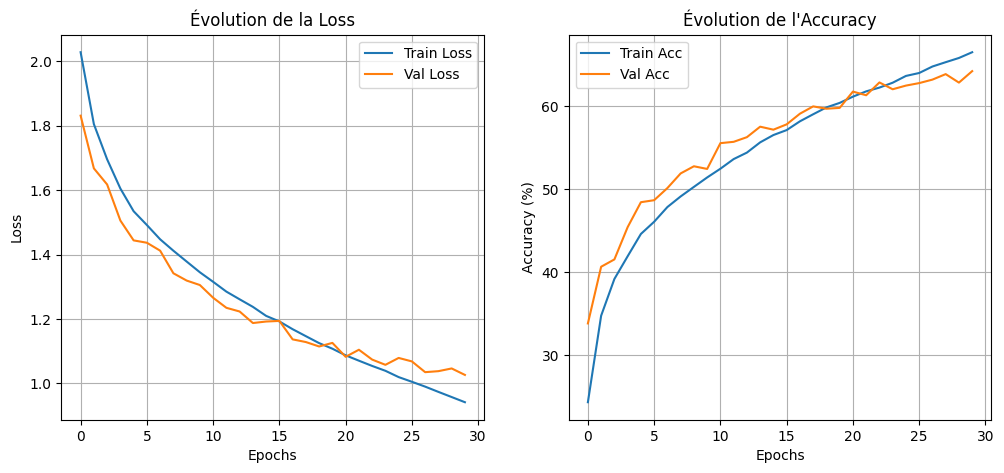

Évaluation du modèle...


100%|██████████| 157/157 [00:02<00:00, 61.74it/s]



Accuracy Finale sur le jeu de test : 63.46%


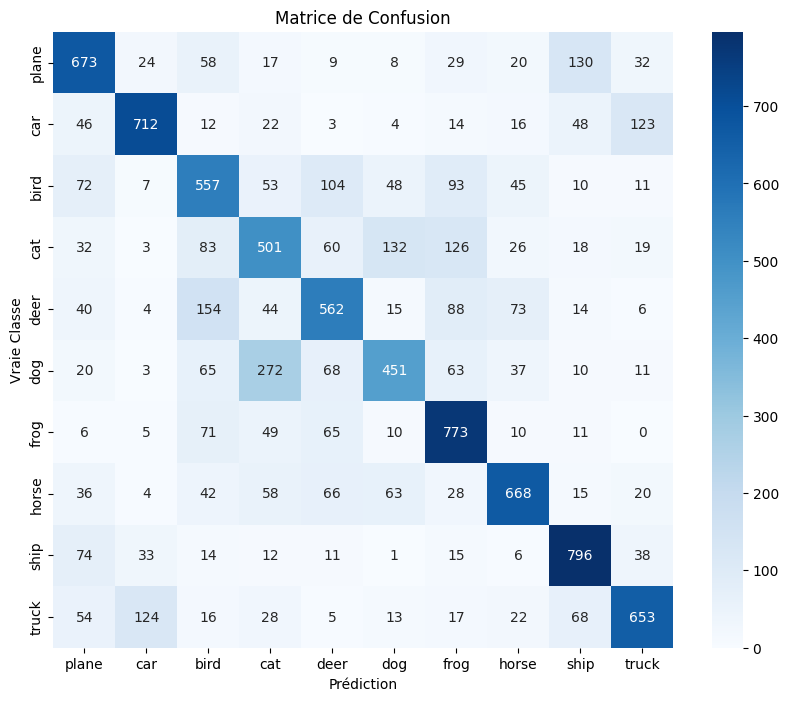

In [ ]:
# Lancer l'entraînement (Commence avec 10 ou 20 epochs pour tester)
history_vit = train_model(model_vit, trainloader, valloader, criterion, optimizer, num_epochs=30, device=device)

# Lancer l'évaluation finale
evaluate_model(model_vit, testloader, classes, device=device)

# Tiny ImageNet

## CNN

### Preprocessing

In [19]:
class HFDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']
        label = item['label']

        # Conversion forcée en RGB (certaines images sont en N&B)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

print("Chargement de Tiny ImageNet...")
ds = load_dataset("zh-plus/tiny-imagenet")

batch_size = 64 # le réseau traite par paquets de 64 imgs au lieu de 50000 (sinon explosion de la mémoire RAM/GPU)
learning_rate = 0.001
epochs = 10

transform_train = transforms.Compose([
    transforms.RandomCrop(64, padding=4), # data augmentation : recadrage aléatoire avec padding de 4 pixels
    transforms.RandomHorizontalFlip(p=0.5), # data augmentation : retournement horizontal aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1), # data augmentation : modification aléatoire de la luminosité, contraste et saturation
    transforms.ToTensor(), # img classique codée entre 0 et 255, ici on divise par 255 pour avoir entre 0 et 1 (meilleur pour l'apprentissage)
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # apprentissage rapide si les données ont m=0 et sigma proche de 1 (mR, mG, mB),(sigmaR, sigmaG, sigmaB)

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # valeurs prise sur google (normalisation cifar-10)
])


full_train_dataset = HFDatasetWrapper(ds['train'], transform=transform_train)
test_dataset = HFDatasetWrapper(ds['valid'], transform=transform_test)

val_size = 10000
train_size = len(full_train_dataset) - val_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

# DataLoaders
batch_size = 64
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Données prêtes : Train ({len(train_dataset)}), Val ({len(val_dataset)}), Test ({len(test_dataset)})")

Chargement de Tiny ImageNet...
Données prêtes : Train (90000), Val (10000), Test (10000)


### VGG

Epoch [1/20] Train Loss: 4.5418 | Val Loss: 4.1257 | Train Acc: 6.76% | Val Acc: 11.46%
Epoch [2/20] Train Loss: 3.9315 | Val Loss: 3.9030 | Train Acc: 13.57% | Val Acc: 15.16%
Epoch [3/20] Train Loss: 3.6739 | Val Loss: 3.4800 | Train Acc: 17.79% | Val Acc: 22.46%
Epoch [4/20] Train Loss: 3.4827 | Val Loss: 3.3634 | Train Acc: 21.67% | Val Acc: 23.98%
Epoch [5/20] Train Loss: 3.3306 | Val Loss: 3.2396 | Train Acc: 24.27% | Val Acc: 26.69%
Epoch [6/20] Train Loss: 3.2014 | Val Loss: 3.2819 | Train Acc: 26.63% | Val Acc: 26.46%
Epoch [7/20] Train Loss: 3.0970 | Val Loss: 3.0292 | Train Acc: 28.29% | Val Acc: 30.60%
Epoch [8/20] Train Loss: 3.0092 | Val Loss: 2.8654 | Train Acc: 30.40% | Val Acc: 33.47%
Epoch [9/20] Train Loss: 2.9403 | Val Loss: 2.9587 | Train Acc: 31.66% | Val Acc: 31.94%
Epoch [10/20] Train Loss: 2.8720 | Val Loss: 2.9230 | Train Acc: 33.01% | Val Acc: 32.62%
Epoch [11/20] Train Loss: 2.8223 | Val Loss: 2.7563 | Train Acc: 33.87% | Val Acc: 36.69%
Epoch [12/20] Train 

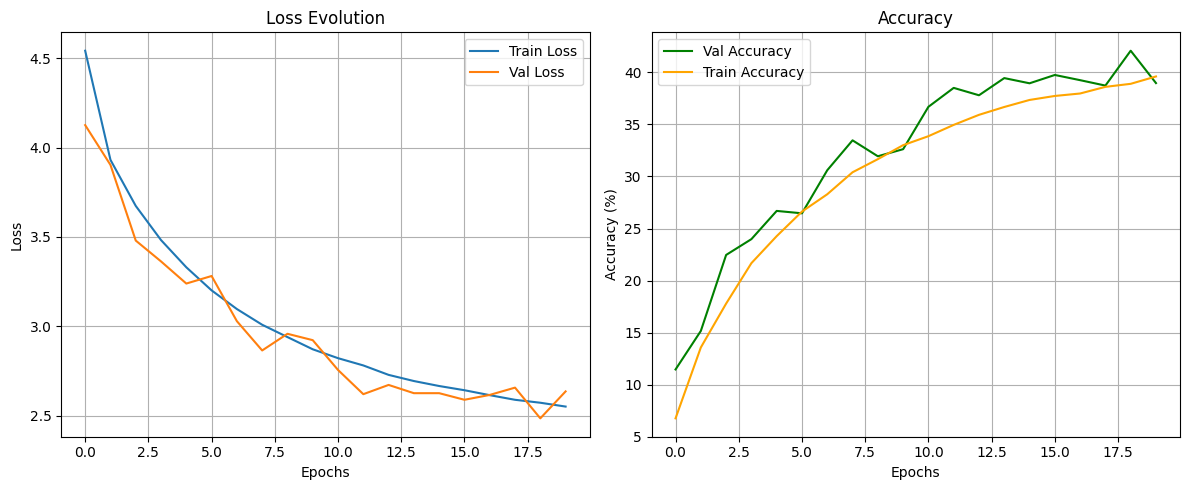

Accuracy finale sur le jeu de test (10,000 images) : 41.67 %


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_tiny.parameters(), lr=learning_rate, weight_decay=1e-4) # pénalité L2 pour éviter l'overfitting
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
history_vgg_tiny = train_model_cnn(vgg_tiny, trainloader, valloader, epochs=20, patience=5)



import os
os.makedirs('models', exist_ok=True)
save_path = 'models/vgg_tiny_final.pth'
torch.save(vgg_tiny.state_dict(), save_path)

print(f"Modèle sauvegardé avec succès ici : {save_path}")
plot_training_results_cnn(history_vgg_tiny)
evaluate_test_accuracy_cnn(vgg_tiny, testloader, device)

### RESNET

Epoch [1/10] Train Loss: 4.7118 | Val Loss: 4.2963 | Train Acc: 4.92% | Val Acc: 8.62%
Epoch [2/10] Train Loss: 4.0325 | Val Loss: 3.8410 | Train Acc: 11.55% | Val Acc: 15.14%
Epoch [3/10] Train Loss: 3.6335 | Val Loss: 3.4136 | Train Acc: 17.77% | Val Acc: 21.89%
Epoch [4/10] Train Loss: 3.3581 | Val Loss: 3.1565 | Train Acc: 22.60% | Val Acc: 26.79%
Epoch [5/10] Train Loss: 3.1438 | Val Loss: 3.0325 | Train Acc: 26.78% | Val Acc: 29.21%
Epoch [6/10] Train Loss: 2.9904 | Val Loss: 2.8465 | Train Acc: 29.65% | Val Acc: 33.16%
Epoch [7/10] Train Loss: 2.8494 | Val Loss: 2.7410 | Train Acc: 32.58% | Val Acc: 35.16%
Epoch [8/10] Train Loss: 2.7379 | Val Loss: 2.6289 | Train Acc: 34.88% | Val Acc: 37.31%
Epoch [9/10] Train Loss: 2.6397 | Val Loss: 2.5240 | Train Acc: 36.83% | Val Acc: 39.84%
Epoch [10/10] Train Loss: 2.5483 | Val Loss: 2.5347 | Train Acc: 38.84% | Val Acc: 39.72%
Temps total d'entraînement : 1887.90s


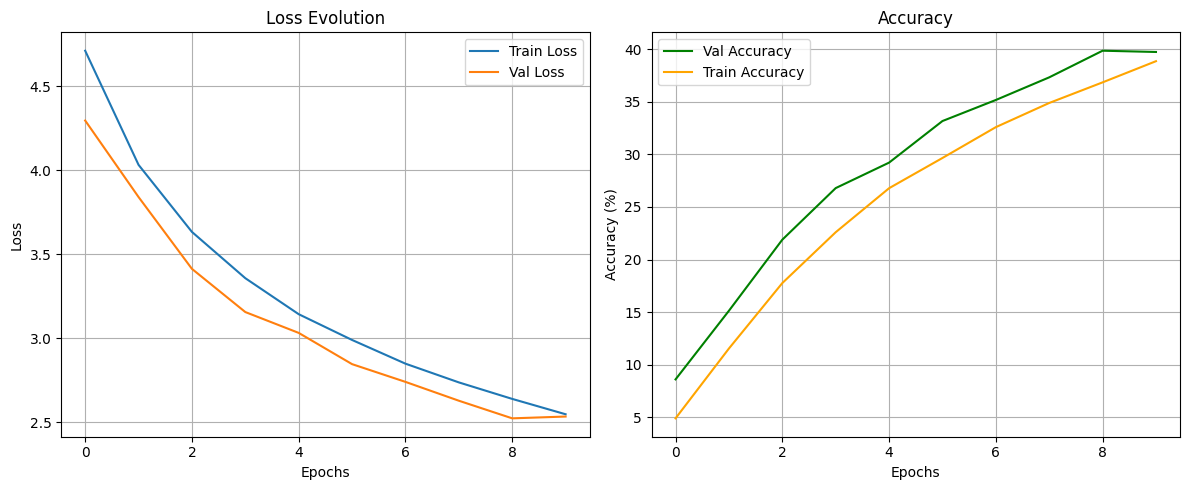

Accuracy finale sur le jeu de test (10,000 images) : 40.86 %


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_tiny.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
history_resnet_tiny = train_model_cnn(resnet_tiny, trainloader, valloader, epochs=10, patience=5)


import os
os.makedirs('models', exist_ok=True)
save_path = 'models/resnet_tiny_final.pth'
torch.save(resnet_tiny.state_dict(), save_path)

plot_training_results_cnn(history_resnet_tiny)
evaluate_test_accuracy_cnn(resnet_tiny, testloader, device)

## ViT

In [ ]:
from datasets import load_dataset
ds = load_dataset("zh-plus/tiny-imagenet")
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-1359597a978bc4(…):   0%|          | 0.00/146M [00:00<?, ?B/s]

data/valid-00000-of-00001-70d52db3c749a9(…):   0%|          | 0.00/14.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/100000 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [22]:
class HFDatasetWrapper(torch.utils.data.Dataset):
    """
    Sert de pont entre le dataset Hugging Face et PyTorch.
    Convertit les images en RGB
    """
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        item = self.hf_dataset[idx]
        image = item['image']
        label = item['label']

        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_wrapper = HFDatasetWrapper(ds['train'], transform=transform)
tiny_test_dataset = HFDatasetWrapper(ds['valid'], transform=transform)

val_size = int(0.1 * len(full_train_wrapper)) # 10 000 images
train_size = len(full_train_wrapper) - val_size # 90 000 images
generator = torch.Generator().manual_seed(42)
tiny_train_dataset, tiny_val_dataset = random_split(full_train_wrapper, [train_size, val_size], generator=generator)

batch_size = 64
trainloader_tiny = DataLoader(tiny_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader_tiny = DataLoader(tiny_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader_tiny = DataLoader(tiny_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Split Tiny ImageNet terminé :")
print(f"- Train      : {len(tiny_train_dataset)} images (pour apprendre)")
print(f"- Validation : {len(tiny_val_dataset)} images (pour surveiller)")
print(f"- Test       : {len(tiny_test_dataset)} images (pour le verdict final)")

Split Tiny ImageNet terminé :
- Train      : 90000 images (pour apprendre)
- Validation : 10000 images (pour surveiller)
- Test       : 10000 images (pour le verdict final)


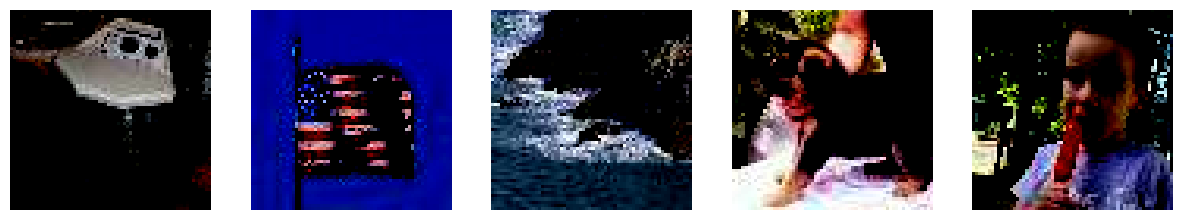

In [ ]:
# images aléatoires du trainloader
dataiter_tiny = iter(trainloader_tiny)
images, labels = next(dataiter_tiny)


plt.figure(figsize=(15, 5))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    imshow(images[i])
    plt.axis('off')

plt.show()

In [ ]:
model_vit_tiny = ViT(img_size=64, patch_size=8, num_classes=200, embed_dim=128, depth=6, num_heads=4).to(device)

optimizer = optim.AdamW(model_vit_tiny.parameters(), lr=3e-4, weight_decay=5e-2)
criterion = nn.CrossEntropyLoss()

Démarrage de l'entraînement pour 30 époques...


Epoch 1/30 | Train Loss: 4.9379 Acc: 3.42% | Val Loss: 4.6513 Acc: 6.14% | Time: 83.8s


Epoch 2/30 | Train Loss: 4.5200 Acc: 7.80% | Val Loss: 4.3229 Acc: 10.37% | Time: 82.3s


Epoch 3/30 | Train Loss: 4.2522 Acc: 11.29% | Val Loss: 4.1021 Acc: 13.68% | Time: 82.2s


Epoch 4/30 | Train Loss: 4.0619 Acc: 13.84% | Val Loss: 3.9780 Acc: 15.45% | Time: 83.6s


Epoch 5/30 | Train Loss: 3.9335 Acc: 15.60% | Val Loss: 3.8830 Acc: 16.55% | Time: 82.5s


Epoch 6/30 | Train Loss: 3.8244 Acc: 17.38% | Val Loss: 3.7871 Acc: 17.92% | Time: 81.9s


Epoch 7/30 | Train Loss: 3.7308 Acc: 18.76% | Val Loss: 3.7109 Acc: 19.12% | Time: 84.8s


Epoch 8/30 | Train Loss: 3.6487 Acc: 19.91% | Val Loss: 3.6424 Acc: 20.13% | Time: 83.8s


Epoch 9/30 | Train Loss: 3.5782 Acc: 20.89% | Val Loss: 3.6240 Acc: 20.25% | Time: 84.6s


Epoch 10/30 | Train Loss: 3.5101 Acc: 22.14% | Val Loss: 3.5340 Acc: 21.77% | Time: 83.6s


Epoch 11/30 | Train Loss: 3.4490 Acc: 23.01% | Val Loss: 3.5005 Acc: 22.91% | Time: 84.5s


Epoch 12/30 | Train Loss: 3.3854 Acc: 24.07% | Val Loss: 3.4544 Acc: 22.79% | Time: 83.8s


Epoch 13/30 | Train Loss: 3.3237 Acc: 25.11% | Val Loss: 3.4369 Acc: 23.62% | Time: 83.9s


Epoch 14/30 | Train Loss: 3.2687 Acc: 25.95% | Val Loss: 3.4082 Acc: 23.86% | Time: 84.5s


Epoch 15/30 | Train Loss: 3.2130 Acc: 26.99% | Val Loss: 3.3454 Acc: 25.12% | Time: 83.4s


Epoch 16/30 | Train Loss: 3.1602 Acc: 27.62% | Val Loss: 3.3352 Acc: 25.74% | Time: 84.9s


Epoch 17/30 | Train Loss: 3.1101 Acc: 28.62% | Val Loss: 3.3210 Acc: 25.60% | Time: 83.6s


Epoch 18/30 | Train Loss: 3.0637 Acc: 29.37% | Val Loss: 3.2892 Acc: 26.25% | Time: 84.5s


Epoch 19/30 | Train Loss: 3.0182 Acc: 30.20% | Val Loss: 3.2585 Acc: 26.97% | Time: 83.7s


Epoch 20/30 | Train Loss: 2.9762 Acc: 30.86% | Val Loss: 3.2208 Acc: 26.97% | Time: 83.7s


Epoch 21/30 | Train Loss: 2.9326 Acc: 31.70% | Val Loss: 3.2116 Acc: 28.03% | Time: 83.5s


Epoch 22/30 | Train Loss: 2.8966 Acc: 32.31% | Val Loss: 3.2081 Acc: 27.61% | Time: 83.0s


Epoch 23/30 | Train Loss: 2.8536 Acc: 33.09% | Val Loss: 3.1710 Acc: 28.59% | Time: 85.5s


Epoch 24/30 | Train Loss: 2.8249 Acc: 33.61% | Val Loss: 3.1804 Acc: 28.07% | Time: 83.7s


Epoch 25/30 | Train Loss: 2.7838 Acc: 34.37% | Val Loss: 3.1033 Acc: 29.46% | Time: 85.7s


Epoch 26/30 | Train Loss: 2.7504 Acc: 34.95% | Val Loss: 3.0964 Acc: 29.77% | Time: 84.0s


Epoch 27/30 | Train Loss: 2.7186 Acc: 35.47% | Val Loss: 3.1205 Acc: 29.63% | Time: 85.5s


Epoch 28/30 | Train Loss: 2.6922 Acc: 36.05% | Val Loss: 3.1355 Acc: 29.28% | Time: 84.5s


Epoch 29/30 | Train Loss: 2.6606 Acc: 36.40% | Val Loss: 3.1203 Acc: 29.44% | Time: 84.3s


Epoch 30/30 | Train Loss: 2.6326 Acc: 36.93% | Val Loss: 3.0896 Acc: 30.41% | Time: 84.8s


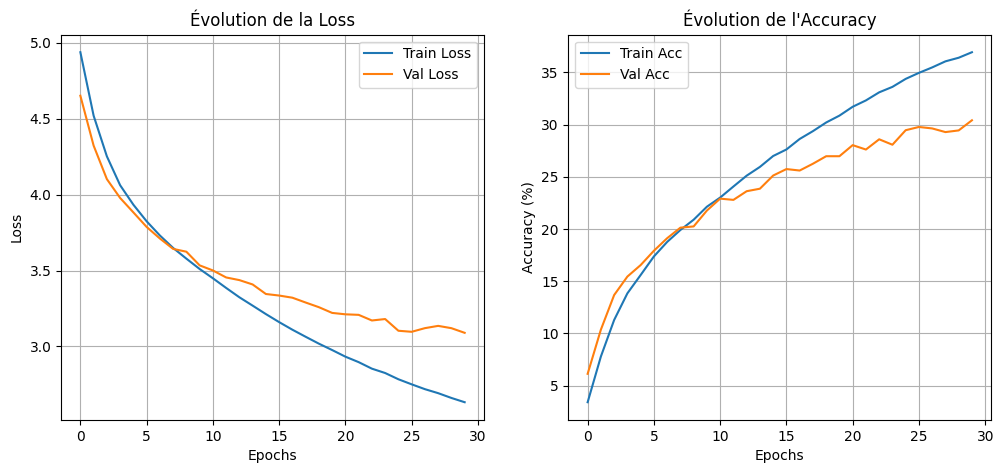

Évaluation du modèle...


100%|██████████| 157/157 [00:05<00:00, 27.65it/s]


Accuracy Finale sur le jeu de test : 29.78%


In [ ]:
history_vit = train_model(model_vit_tiny, trainloader_tiny, valloader_tiny, criterion, optimizer, num_epochs=30, device=device)
classes_tiny = ds['train'].features['label'].names
evaluate_model(model_vit_tiny, testloader_tiny, classes_tiny, device=device)
# 40 min d'entrainment